# Interpreting random sPHNNs

In [1]:
import sys; sys.path.append('../..')   # Allow relative imports from the parent folder

import jax
import jax.numpy as jnp
import jax.random as jr

import numpy as np

import matplotlib.pyplot as plt

from dynax.function_models import FICNN, LyapunovNN, SkewSymmetricMatrix, SPDMatrix

from dynax.derivative_models import ISPHS
from dynax import constraints

import matplotlib.pyplot as plt

#### Create random sPHNN

In [2]:
key = jr.key(0)
j_key, r_key, h_key = jr.split(key, 3)

state_size = 2

J = SkewSymmetricMatrix(state_size, key=j_key)
R = SPDMatrix(state_size, key=r_key)

ficnn = FICNN(state_size, 'scalar', key=h_key)
H = LyapunovNN(ficnn, minimum=jnp.zeros(state_size))

sphnn = ISPHS(H, J, R)

sphnn = constraints.resolve_constraints(sphnn)

#### Plot untrained dynamics

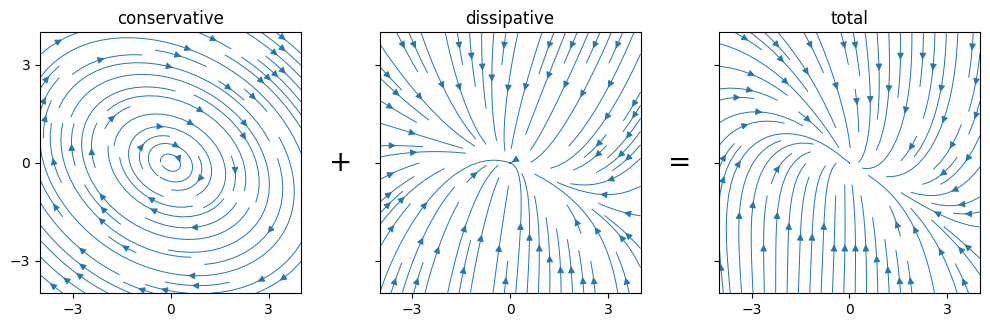

In [3]:
x1, x2 = 2*(jnp.linspace(-4, 4, 100),)
X1, X2 = np.meshgrid(x1, x2)
X = np.stack([X1, X2], axis=-1)

X_t_nomi = jax.vmap(jax.vmap(sphnn, in_axes=(None, 0, None)), in_axes=(None, 0, None))(None, X, None)
X_t_cons = jax.vmap(jax.vmap(sphnn.get_conservative_dynamics, in_axes=(None, 0, None)), in_axes=(None, 0, None))(None, X, None)
X_t_diss = jax.vmap(jax.vmap(sphnn.get_dissipative_dynamics, in_axes=(None, 0, None)), in_axes=(None, 0, None))(None, X, None)

data = {
    'conservative': X_t_cons,
    'dissipative': X_t_diss,
    'total': X_t_nomi,
}

fig, axes = plt.subplots(1, 3, sharex=True, sharey=True, figsize=(10,4))

for ax, (label, X_t) in zip(axes, data.items()):
    X1_t, X2_t = np.transpose(X_t, [2, 0, 1])
    sp = ax.streamplot(X1, X2, X1_t, X2_t, broken_streamlines=True, density=0.8, linewidth=0.7)
    ax.set(
        xlim=[min(x1), max(x1)],
        ylim=[min(x2), max(x2)],
        xticks=[-3,0,3],
        yticks=[-3,0,3],
        title=label,
    )
    ax.set_aspect('equal', 'box')

fig.tight_layout()
fig.subplots_adjust(wspace=0.3, hspace=0)

ax0_pos = axes[0].get_position()
ax1_pos = axes[1].get_position()
ax2_pos = axes[2].get_position()
fig.text((ax0_pos.x1 + ax1_pos.x0)/2, 0.5, '+', fontsize=20, ha='center', va='center')
fig.text((ax1_pos.x1 + ax2_pos.x0)/2, 0.5, '=', fontsize=20, ha='center', va='center')

plt.show()